### Student : Hussin Almoustafa
### Studentennummer : 1776495

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math
import random

## Pseudorandom number generater

In [12]:
import warnings
from warnings import warn
warnings.filterwarnings('ignore')

In [ ]:
class Mersenne: 
    def __init__(self, seed=1234):
        """ Initialize pseudorandom number generator .Accepteert een
         integer of floating-point seed, dat wordt gebruikt in
         combinatie met een integer vermenigvuldiger, k, en de
         Mersenne priemgetal, j, om pseudo-willekeurige getallen eruit te "draaien"
         van laatstgenoemde. Dit lid initialiseert ook de bestelling
         van de periode van de generator, zodat leden zwevend en
         integer kan een waarschuwing afgeven wanneer de generatie op het punt staat
         cyclus en wordt dus niet zo pseudo-willekeurig."""
        
        self.seed = seed
        self.j = 2 ** 31 - 1
        self.k = 16807
        self.period = 2 ** 30

In [10]:
def randomNumber(self, interval=None, count=1, typeNb="int"):
        """
       Retourneer een pseudo-willekeurige float of int. De standaardwaarde is één float of int tussen 0 en 1.
         Geef een tuple of lijst door, (a,b), om een getal met drijvende komma op [a,b] te retourneren.
         Als telling 1 is, wordt een enkel getal geretourneerd, anders wordt een lijst met getallen geretourneerd. """ 
        
        randFloat = lambda i, randomness: (i[1] - i[0]) * randomness + i[0] if i is not None else randomness
        randInt = lambda i, randomness: int((i[1] - i[0] + 1) * randomness + i[0]) if i is not None else int(randomness<0.50)
        exactuables = {"int": randInt, "float": randFloat}
        relevantExactuable = exactuables[typeNb]
        results = []
        
        for i in range(count):
            self.seed = (self.k * self.seed) % self.j
            randomNess = (self.seed / self.j)
            results.append(relevantExactuable(interval, randomNess))    
            self.period -= 1
            if self.period == 0: warn("Pseudorandom period nearing!!", category=ResourceWarning)
        
        if count == 1:
            return results.pop()
        else:
            return results

## Data : 
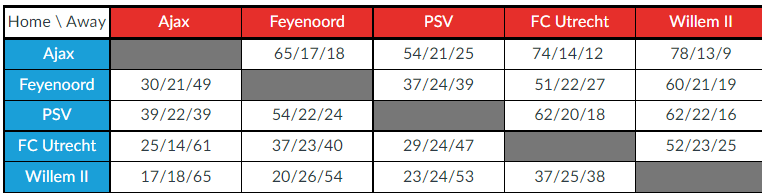

In [13]:
Ajax      =  [None, [65,17,18], [54,21,25], [74,14,12], [78,13,9]]
Feyenoord =  [[30,21,49], None, [37,24,39], [51,22,27], [60,21,19]]
PSV       =  [[39,22,39], [54,22,24], None, [62,20,18], [62,22,16]]
FCUtrecht =  [[25,14,61], [37,23,40], [29,24,47], None, [52,23,25]]
WillemII  =  [[17,18,65], [20,26,54], [23,24,53], [37,25,38], None]

In [14]:
teams = ["Ajax", "Feyenoord", "PSV", "FCUtrecht", "WillemII"]
table = pd.DataFrame([Ajax, Feyenoord, PSV, FCUtrecht, WillemII])
table = table.set_index(pd.Index(teams))
table.columns = teams

In [15]:
table

,Ajax,Feyenoord,PSV,FCUtrecht,WillemII
Ajax,None,"[65, 17, 18]","[54, 21, 25]","[74, 14, 12]","[78, 13, 9]"
Feyenoord,"[30, 21, 49]",None,"[37, 24, 39]","[51, 22, 27]","[60, 21, 19]"
PSV,"[39, 22, 39]","[54, 22, 24]",None,"[62, 20, 18]","[62, 22, 16]"
FCUtrecht,"[25, 14, 61]","[37, 23, 40]","[29, 24, 47]",None,"[52, 23, 25]"
WillemII,"[17, 18, 65]","[20, 26, 54]","[23, 24, 53]","[37, 25, 38]",None


In [46]:
"""Maakt een lijst met 100 items. Als de winkans 30 is, dan zijn 30 items in deze lijst 3 (u krijgt 3 punten voor een overwinning)
Kiest vervolgens willekeurig een item in deze lijst """

determinHomePoints = lambda chan: ([3]*chan[0] + [1]*chan[1] + [0]*chan[2])[random.randint(0,99)] if chan != None else None
determinResult = lambda homePoints: (homePoints,{3:0, 1:1, 0:3}[homePoints]) if homePoints != None else None


## Simualtion : 

In [47]:
def runSim(version="base"):
    leaqueTable = table.copy()
    dictOfTeams = {team:0 for team in teams}
    for index, row in leaqueTable.iterrows():
        for colum in list(leaqueTable):
            pointsForHomeTeam = determinHomePoints(leaqueTable[colum][index])
            result = determinResult(pointsForHomeTeam)
            if result != None:
                # colum == awayteam index == hometeam
                dictOfTeams[index] += result[0]
                dictOfTeams[colum] += result[1]

    ranking = pd.Series(dictOfTeams).sort_values(ascending=False)
    return ranking

In [48]:
def runSimulations(numberOfSimulations, version="base"):
    rankingNumbersDict = {i+1:0 for i in range(len(teams))}
    rankingTeams = {team: rankingNumbersDict.copy() for team in teams}
    for simNummer in range(numberOfSimulations):
        seasonRanking = runSim()
        ii = 0
        for i, v in seasonRanking.iteritems():
            rankingTeams[i][ii + 1] += 1
            #Controleert of het team niet gelijk staat met het team hierboven
            if (ii+1 != len(seasonRanking)-1) and (v != seasonRanking[ii+1]):
                ii += 1
                
    return rankingTeams 

In [49]:
getSimulationResults = lambda numSim, version="base": (pd.DataFrame.from_dict(runSimulations(numSim, version), orient='index') /numSim) * 100
print(getSimulationResults(350))

                   1          2          3          4    5
Ajax       66.857143  22.571429   8.571429   2.000000  0.0
Feyenoord  13.714286  35.142857  31.714286  19.428571  0.0
PSV        28.285714  36.857143  22.571429  12.285714  0.0
FCUtrecht   6.857143  18.285714  29.428571  45.428571  0.0
WillemII    3.428571  10.285714  28.857143  57.428571  0.0


De bovenstaande similatie werkt wel maar het doel van een simulatie is toch het antwoord geven op een vraag. Ondaks dat dit een leuke similatie is om te doen hebben we niet echt antwoord gegeven op de vraag. 

Mijn vraag luid als volgd. Heeft de willekeur van de volgorde waarin de werstreiden gespeeld worden effect op het de freqentie waarmee bepaalde teams op bepaalde posities eindigen.

In de vorige opdracht heeft het resultaat van de vorige wedstijden geen effect gehad op de kans van winnen van de huidigen wedstijd. In die simulatie zou het antwoord dus duidelijk nee zijn.

Het effect van moraal is niet mee genomen (je kan ook stellen dat die al inbegrepen zit in het persentage in dat geval is de willekeur van moraal niet mee genomen).

Laten wij er van uitgaan dat een team dat 3 wedstijden achter elkaar heeft gewonnen vertrouwen heeft in hun spel en dat dit hun win kans vergroot. Nu maakt de volgorde van de wedstijden potentieel wel uit.

We kunnen iets als het volgende stellen
[Game1, Game2, Game3] = Een lijst met de laatste 3 wedstijden

if [Won, Won, Won]: winkans + 15%

if [Any, Any, Won]: winkans + 5%

if [Any, Any, Loss]: winkans - 5%

if [Loss, Loss, Loss]: winkans - 15%

In [52]:
def determinMotivation(past):
    if past == [3,3,3]:
        return [10,5,-15]
    elif past == [0,0,0]:
        return [-10,-5,15]
    elif past[-1:] == 3:
        return [5,0,-5]
    elif past[-1:] == 0:
        return [-5,0,5]
    else:
        return [0,0,0]

def runSim(version="base"):
    leaqueTable = table.copy()
    dictOfTeams = {team:0 for team in teams}
    pastScoresDict = {team:[None,None,None] for team in teams}
    for index, row in leaqueTable.iterrows():
        for colum in list(leaqueTable):
            pastScore = pastScoresDict[index]
            chanses = leaqueTable[colum][index]
            if chanses == None:
                continue
            elif version == "morale":   
                chanses = [a+b for a, b in zip(determinMotivation(pastScore), leaqueTable[colum][index])]
            
            pointsForHomeTeam = determinHomePoints(chanses)
            result = determinResult(pointsForHomeTeam)
            # colum == awayteam index == hometeam
            dictOfTeams[index] += result[0]
            dictOfTeams[colum] += result[1]
            pastScoresDict[index] = [result[0]] + [pastScore[0]] + [pastScore[1]]
            pastScoreAway = pastScoresDict[colum]
            pastScoresDict[colum] = [result[1]] + [pastScoreAway[0]] + [pastScoreAway[1]]

    ranking = pd.Series(dictOfTeams).sort_values(ascending=False)
    return ranking

In [53]:
print(getSimulationResults(350))
print(getSimulationResults(350, version="morale"))

                   1          2          3          4    5
Ajax       62.571429  25.714286  10.000000   1.714286  0.0
Feyenoord  14.571429  29.714286  33.714286  22.000000  0.0
PSV        32.857143  38.857143  18.000000  10.285714  0.0
FCUtrecht   5.714286  20.285714  31.142857  42.857143  0.0
WillemII    4.000000  13.714286  28.285714  54.000000  0.0
                   1          2          3          4    5
Ajax       63.142857  26.000000   7.428571   3.428571  0.0
Feyenoord  14.000000  27.142857  36.571429  22.285714  0.0
PSV        28.857143  40.571429  22.857143   7.714286  0.0
FCUtrecht   6.571429  17.428571  29.142857  46.857143  0.0
WillemII    2.571429  10.571429  25.428571  61.428571  0.0


Nog geen echte verchil. 

In [55]:
for i in range(50,550,100):
    print((getSimulationResults(350) - getSimulationResults(350, version="morale")).round())


             1    2    3    4    5
Ajax      -1.0  0.0  1.0  0.0  0.0
Feyenoord  3.0  0.0  3.0 -6.0  0.0
PSV        4.0 -4.0 -1.0  1.0  0.0
FCUtrecht -1.0  5.0  0.0 -3.0  0.0
WillemII   2.0 -1.0 -1.0 -1.0  0.0
             1    2    3    4    5
Ajax      -2.0 -1.0  2.0  1.0  0.0
Feyenoord -1.0  2.0 -1.0  0.0  0.0
PSV        2.0  1.0 -2.0 -1.0  0.0
FCUtrecht -1.0  5.0 -4.0 -0.0  0.0
WillemII   0.0 -3.0 -2.0  5.0  0.0
             1    2    3    4    5
Ajax       1.0  1.0 -1.0  0.0  0.0
Feyenoord  0.0 -2.0  1.0  1.0  0.0
PSV       -0.0 -1.0  3.0 -1.0  0.0
FCUtrecht  0.0  1.0 -5.0  3.0  0.0
WillemII   1.0 -1.0  0.0 -0.0  0.0
             1    2    3    4    5
Ajax       7.0 -5.0 -2.0  0.0  0.0
Feyenoord -1.0 -6.0  8.0 -0.0  0.0
PSV       -4.0  4.0 -0.0 -0.0  0.0
FCUtrecht -0.0  0.0  1.0 -1.0  0.0
WillemII   0.0 -1.0 -3.0  4.0  0.0
             1    2    3    4    5
Ajax       2.0 -2.0  1.0 -1.0  0.0
Feyenoord -1.0 -1.0 -2.0  4.0  0.0
PSV        3.0 -1.0 -1.0 -2.0  0.0
FCUtrecht -1.0  0.0 

Aan de verschillen is geen echte trend te zien. Voor deze simulatie is het niet belangrijk om moraal met je mee te dragen Poisson-verdeling Breuken zijn nu niet inbegrepen. Hiervoor kunnen we een Poissonverdeling maken. Hiervoor hebben we elk team nodig: hoeveel scoren ze gemiddeld thuis (HS), hoeveel scoren ze gemiddeld (AS), hoeveel krijgen ze gemiddeld thuis (HC), hoeveel krijgen ze gemiddeld (AC) Deze staan ​​in de onderstaande tabel:

In [56]:
Ajax = [3.2, 0.9, 3.1, 0.6]
Feyenoord =[2.4, 1.1, 2.2, 0.8]
PSV = [2.1, 0.7, 1.8, 1.3]
FCUtrecht = [1.9, 1.2, 3, 2.4]
WillemII = [1.4, 1.7, 1, 1.5]
teams = ["Ajax", "Feyenoord", "PSV", "FCUtrecht", "WillemII"]
averScoreDF = pd.DataFrame([Ajax, Feyenoord, PSV, FCUtrecht, WillemII])
averScoreDF = averScoreDF.set_index(pd.Index(teams))
averScoreDF.columns = ["HS", "HC", "AS", "AC"]

In [59]:
#berekend de kans op een gegeven score gegeven een gemiddelde score
applyPoisson = lambda score, averScore: (averScore**score)*(math.e**-averScore) / math.factorial(score)
getDistribution = lambda averScore: [applyPoisson(i,averScore) for i in range(5)]

def listOfChoises(dis):
    choises = []
    for i in range(len(dis)):
        choises += [i] * round(dis[i]*100)
    return choises 

def getScore(averScore):
    distribution = getDistribution(averScore)
    choises = listOfChoises(distribution)
    score = choises[random.randint(0,len(choises)-1)]
    return score

Omdat we natuurlijk willen weten of deze formulering correct is, moeten we de simulatie meerdere keren uitvoeren en deze vervolgens vergelijken met de waarschijnlijkheden. Hieronder zien we dat de frequentie van voorkomen van een score overeenkomt met de kans op die score. dus er gebeurt niets raars

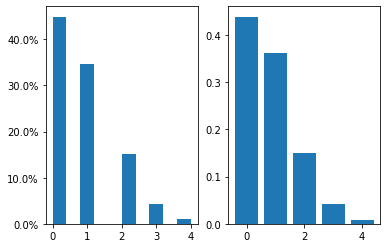

In [60]:
results = [getScore(0.824) for i in range(1000)]
plt.subplot(1, 2, 1)
plt.hist(results, weights=np.ones(len(results)) / len(results))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.subplot(1, 2, 2)
dis = getDistribution(0.824)
forPlot = {dis.index(i):i for i in dis}
plt.bar(range(5), getDistribution(0.824))
plt.show()

In [61]:
def makeSchedule(teams):
    ammountTeams = len(teams)
    schedule = pd.DataFrame(np.zeros((ammountTeams, ammountTeams)))
    schedule.columns = teams
    schedule.index = teams
    return schedule

def playSchedule(schedule, averScoreDF):
    for column in schedule:
        for index, row in schedule.iterrows():
            if index == column:
                schedule[column][index] = None
            else:
                scoreChanseHome = (averScoreDF["HS"][index] + averScoreDF["AC"][column]) /2
                scoreChanseAway = (averScoreDF["AS"][column] + averScoreDF["HC"][index]) /2
                gameResult = "{}:{}".format(getScore(scoreChanseHome), getScore(scoreChanseAway))
                schedule[column][index] = gameResult
    return schedule

In [62]:
played_schedule = playSchedule(makeSchedule(teams), averScoreDF)
print(played_schedule)

          Ajax Feyenoord   PSV FCUtrecht WillemII
Ajax       NaN       3:4   3:1       1:1      2:0
Feyenoord  2:3      None   3:0       1:2      3:0
PSV        1:2       2:0  None       2:2      0:2
FCUtrecht  0:2       1:0   2:1      None      0:2
WillemII   1:1       1:4   0:2       2:1     None


In [63]:
for i in range(10):
    played_schedule = playSchedule(makeSchedule(teams), averScoreDF)
    results = played_schedule.copy()
    results = results.replace({np.nan: None})
    def funcy(x):
        temp_list = []
        for value in x:
            if value == None:
                temp_list.append(value)
            elif int(value[0]) > int(value[2]):
                temp_list.append(3)
            elif int(value[0]) > int(value[2]):
                temp_list.append(0)
            else:
                temp_list.append(1)
        return pd.Series(temp_list)

    results = results.apply(lambda x: funcy(x))
    print(results.sum(axis=1))

0    12.0
1     6.0
2    10.0
3     6.0
4     6.0
dtype: float64
0    12.0
1     6.0
2     6.0
3     4.0
4     4.0
dtype: float64
0    12.0
1     8.0
2    12.0
3     6.0
4     6.0
dtype: float64
0    10.0
1     8.0
2     8.0
3     8.0
4     4.0
dtype: float64
0    6.0
1    6.0
2    8.0
3    4.0
4    8.0
dtype: float64
0    10.0
1     6.0
2     6.0
3     6.0
4     8.0
dtype: float64
0    10.0
1    10.0
2     8.0
3    10.0
4     8.0
dtype: float64
0    8.0
1    6.0
2    8.0
3    6.0
4    8.0
dtype: float64
0    8.0
1    8.0
2    6.0
3    8.0
4    8.0
dtype: float64
0     8.0
1     8.0
2    10.0
3     8.0
4     8.0
dtype: float64


## conclusie  :
Na een snelle test merkte ik dat het "betere team" hier beter presteerde